In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import tensorflow as tf
import torch
import os
os.chdir('..')

In [2]:
tickers = ['aapl', 'amd', 'msft', 'intc', 'd', 'sbux', 'atvi',
          'ibm', 'ual', 'vrsn', 't', 'mcd', 'vz']

In [31]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) 
#         for x in dir() if not x.startswith('_') 
#         and x not in sys.modules and x not in ipython_vars], 
#        key=lambda x: x[1], reverse=True)

In [3]:
etf_path = 'iexfinance/Data/ETFs/{}.us.txt'
stock_path = 'iexfinance/Data/Stocks/{}.us.txt'

def read_csv(ticker, is_etf=False):
    path = etf_path.format(ticker) if is_etf else stock_path.format(ticker)
    cur_df = pd.read_csv(path)
    cur_df.drop(['Volume', "OpenInt"], axis=1, inplace=True)
    return cur_df

In [5]:
spy = read_csv('spy', True)
spy_default = spy.copy()
for ticker in tickers:
    ticker_df = read_csv(ticker)
    spy_default = pd.merge(spy_default, 
                           ticker_df, 
                           on='Date', 
                           how='left', 
                           suffixes=('', '_'+ticker))
    

In [4]:
def give_delta_historical(df):
    original_col = df.columns[1:]
    
    # shift days
    for shift_idx in [3, 5, 10, 20, 40]:
        for col in original_col:
            df[col+'_'+str(shift_idx)] = df[col].shift(shift_idx)
    
    # np.log all values
    for item in df:
        if np.issubdtype(df[item].dtype, np.number):
            df[item] = np.log(df[item])
    
    df_values = df.values
    # for lookback
    for row_idx in range(5, df_values.shape[1], 4):
        df_values[:, row_idx:row_idx+4] = df_values[:, 1:5] - \
                                           df_values[:, row_idx:row_idx+4]
    # for today
    for idx in range(len(df_values)-1, 0, -1):
        df_values[idx, 1:5] -= df_values[idx-1, 1:5]
    
    return df_values

In [5]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
spy = read_csv('spy', True)
spy_original = read_csv('spy', True)

spy_from_fn = give_delta_historical(spy)
# x:= revised val, y:= original.shift(-1)
print(spy_from_fn.shape, spy_original.shape)
# Drop NaN here
spy_from_fn = spy_from_fn[40:]
print(spy_from_fn.shape, spy_original.shape)

(3201, 25) (3201, 5)
(3161, 25) (3201, 5)


In [7]:
def process_output_data(spy_original):
    original_columns = spy_original.columns[1:]
    # shift 10, 5
    for col in original_columns:
        spy_original['10_'+str(col)] = spy_original[col].shift(-10)
    for col in original_columns:
        spy_original['5_'+str(col)] = spy_original[col].shift(-5)
    # log_delta
    for col in original_columns:
        spy_original['10_'+col] = np.log(spy_original['10_'+col].values) - \
                                  np.log(spy_original[col].values)
    for col in original_columns:
        spy_original['5_'+col] = np.log(spy_original['5_'+col].values) - \
                                 np.log(spy_original[col].values)
    return spy_original

spy_original = process_output_data(spy_original)

In [8]:
Y = spy_original['10_Open'][40:]
print('X.shape: {}, Y.shape: {}'.format(spy_from_fn.shape, Y.shape))
print('Indecies of NaN in Y:\n {}'.format(np.argwhere(Y.isna())))
print('Drop those rows ...')
delete_from_back = Y.isna().sum()
spy_from_fn = spy_from_fn[:-delete_from_back]
Y = Y[:-delete_from_back].values
# Y = Y.reshape(-1, 1)
print('X.shape: {}, Y.shape: {}'.format(spy_from_fn.shape, Y.shape))

X.shape: (3161, 25), Y.shape: (3161,)
Indecies of NaN in Y:
 [[3151]
 [3152]
 [3153]
 [3154]
 [3155]
 [3156]
 [3157]
 [3158]
 [3159]
 [3160]]
Drop those rows ...
X.shape: (3151, 25), Y.shape: (3151,)


In [9]:
# astype(..., copy=False)???
spy_from_fn[:, 1:] = spy_from_fn[:, 1:].astype(np.float64)

In [10]:
input = pd.DataFrame(spy_from_fn[:, 1:])

In [11]:
# Random sequence data
# train_idx, test_idx = train_test_split(np.arange(len(input)))

# Sequential data
length = int(len(input)* 0.8)
train_idx = np.arange(length)
test_idx = np.arange(length, len(input))

In [12]:
train_df = input.iloc[train_idx]
test_df = input.iloc[test_idx]
print(train_idx.shape, test_idx.shape)
print(train_df.shape, test_df.shape)
# Consider some other y transfroms...
y_train = np.where(Y[train_idx]>0, 1, 0)
y_test = np.where(Y[test_idx]>0, 1, 0)
y_train.sum(), y_test.sum()

(2520,) (631,)
(2520, 24) (631, 24)


(1563, 392)

In [13]:
transfomer = [
    ('Data after standard scaling',
        StandardScaler()),
    ('Data after min-max scaling',
        MinMaxScaler()),
    ('Data after max-abs scaling',
        MaxAbsScaler()),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75))),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson')),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')),
    ('Data after sample-wise L2 normalizing',
        Normalizer()),
]

combined = FeatureUnion(transfomer)
combined.fit(train_df)

/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


FeatureUnion(n_jobs=None,
       transformer_list=[('Data after standard scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Data after min-max scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Data after max-abs scaling', MaxAbsScaler(copy=True)), ('Data after robust scaling', RobustScaler(copy=True, q...    subsample=100000)), ('Data after sample-wise L2 normalizing', Normalizer(copy=True, norm='l2'))],
       transformer_weights=None)

In [14]:
x_train_transformed = combined.transform(train_df)
x_test_transformed = combined.transform(test_df)

/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [15]:
x_train_transformed.shape, x_test_transformed.shape

((2520, 192), (631, 192))

In [16]:
class TickerData(Dataset):
    def __init__(self, ticker, x, y):
        '''
        :param ticker: string
        :param x: np.array of x
        :param y: np.array of y
        '''
        self.ticker = ticker
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

In [17]:
from functools import reduce

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Encoder(nn.Module):
    def __init__(self, input_shape, final_output_size):
        super(Encoder, self).__init__()
        self.c1 = nn.Conv1d(input_shape[0],        final_output_size * 2, (4,), 4)
        self.c2 = nn.Conv1d(final_output_size * 2, final_output_size * 1, (1,), 1)
        self.c3 = nn.Conv1d(final_output_size * 1, 1,                     (1,), 1)
        
    def forward(self, x):
        x = self.c1(x)
        x = torch.relu(x)
        x = self.c2(x)
        x = torch.relu(x)
        x = self.c3(x)
        return torch.tanh(x)

class Decoder(nn.Module):
    def __init__(self, input_shape, final_output_size):
        super(Decoder, self).__init__()
        self.c1 = nn.ConvTranspose1d(1,                     
                                     final_output_size * 1, (1,), stride=1)
        self.c2 = nn.ConvTranspose1d(final_output_size * 1, 
                                     final_output_size * 2, (1,), 1)
        self.c3 = nn.ConvTranspose1d(final_output_size * 2, 
                                     input_shape[0],        (4,), 4)
        
    def forward(self, x):
        x = self.c1(x)
        x = torch.relu(x)
        x = self.c2(x)
        x = torch.relu(x)
        x = self.c3(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_shape, final_output_size):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_shape, final_output_size)
        self.decoder = Decoder(input_shape, final_output_size)

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [22]:
spy_dataset = TickerData('spy', x_train_transformed, y_train)

BATCH_SIZE = 64
train_dl = DataLoader(spy_dataset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

In [18]:
model = AutoEncoder((8, 24), 2).cuda()
criterion = nn.MSELoss()

In [19]:
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [53]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2400, 3e-5)

In [31]:
losses = []
num_epochs=400
for epoch in range(num_epochs):
    cur_loss = 0.0
    for data in train_dl:
        x, _ = data
        x = x.reshape(-1, 8, 24).cuda()

        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += loss.item()
    
    losses += [cur_loss]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, loss.data.item()), end='')

epoch [399/399], loss:0.02226

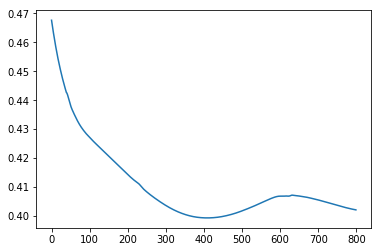

In [36]:
_ = plt.plot(losses)

In [83]:
optimizer = torch.optim.Adam([*model.encoder.c1.parameters(),
                              *model.decoder.c3.parameters()], 
                             lr=1e-3, 
                             weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2400, 3e-5)

In [84]:
losses = []
num_epochs=4000
for epoch in range(num_epochs):
    cur_loss = 0.0
    for data in train_dl:
        x, _ = data
        x = x.reshape(-1, 8, 24).cuda()

        output = torch.relu(model.encoder.c1(x))
        output = model.decoder.c3(output)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += loss.item()
    
    losses += [cur_loss]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, loss.data.item()), end='')

epoch [3999/3999], loss:0.00597

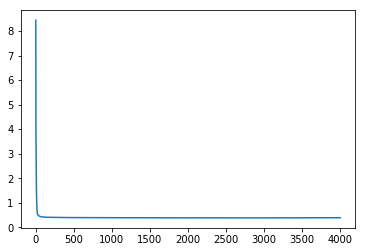

In [85]:
_ = plt.plot(losses)

In [86]:
optimizer = torch.optim.Adam([*model.encoder.c2.parameters(),
                              *model.decoder.c2.parameters()], lr=1e-3, weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2400, 3e-5)

In [88]:
losses = []
num_epochs=1000
for epoch in range(num_epochs):
    cur_loss = 0.0
    for data in train_dl:
        x, _ = data
        x = x.reshape(-1, 8, 24).cuda()

        output = torch.relu(model.encoder.c1(x))
        output = torch.relu(model.encoder.c2(output))
        output = torch.relu(model.decoder.c2(output))
        output = model.decoder.c3(output)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += loss.item()
    
    losses += [cur_loss]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, loss.data.item()), end='')

epoch [999/999], loss:0.37215

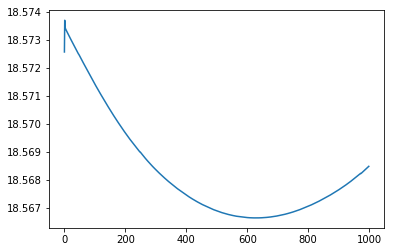

In [89]:
_ = plt.plot(losses)

In [93]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-2, weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2400, 3e-5)

In [96]:
losses = []
num_epochs=2000
for epoch in range(num_epochs):
    cur_loss = 0.0
    for data in train_dl:
        x, _ = data
        x = x.reshape(-1, 8, 24).cuda()

        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += loss.item()
    
    losses += [cur_loss]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, loss.data.item()), end='')

epoch [1999/1999], loss:0.11014

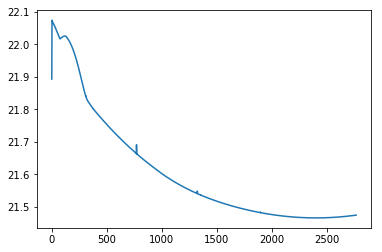

In [95]:
_ = plt.plot(losses)

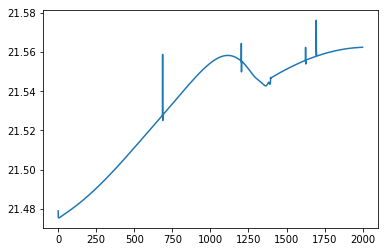

In [97]:
_ = plt.plot(losses)